In [10]:
# IRSS Gauge con tipografía aún más pequeña para que todo quede dentro
# Requiere: matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle
from math import radians, cos, sin

def draw_irss_gauge_tiny(value=33.3,
                         outfile="irss_cafe_gauge_tiny.png",
                         title="",
                         footer="Resultado obtenido del modelo IRSS, junio 2025",
                         size_scale=0.68):  # <— más pequeño que antes
    GREEN  = "#8BC34A"   # Bajo (0–40)
    YELLOW = "#F9A825"   # Medio (41–60)
    RED    = "#E53935"   # Alto (61–100)
    NEEDLE = "#333333"
    TEXT   = "#1a1a1a"

    def ang_of(v):
        v = max(0, min(100, v))
        return 180 - (v/100)*180

    def add_seg(ax, v0, v1, color, R=1.0, r_in=0.70):  # r_in un poco mayor para aro más delgado
        th1, th2 = ang_of(v1), ang_of(v0)
        ax.add_patch(Wedge((0,0), R, theta1=th1, theta2=th2, width=R-r_in,
                           facecolor=color, edgecolor='none'))

    def tick(ax, v, R=1.0):
        a = radians(ang_of(v))
        outer = (R*cos(a), R*sin(a))
        inner = ((R-0.05)*cos(a), (R-0.05)*sin(a))
        ax.plot([inner[0], outer[0]], [inner[1], outer[1]], color=TEXT, lw=1.6)
        r = R + 0.05
        ax.text(r*cos(a), r*sin(a), f"{int(v)}", ha="center", va="center",
                fontsize=int(11*size_scale), color=TEXT)

    def zone_lbl(ax, txt, v0, v1, R=1.0, r_in=0.70, color="#1a1a1a"):
        mid = (v0+v1)/2
        a = radians(ang_of(mid))
        r = (R + r_in)/2
        ax.text(r*cos(a), r*sin(a)+0.018, txt, ha="center", va="center",
                fontsize=int(11*size_scale), color=color, weight="bold")

    fig, ax = plt.subplots(figsize=(9.5,4.4))
    ax.set_aspect("equal")
    ax.axis("off")
    R, r_in = 1.0, 0.70

    add_seg(ax, 0, 40, GREEN, R, r_in)
    add_seg(ax, 40, 60, YELLOW, R, r_in)
    add_seg(ax, 60, 100, RED, R, r_in)

    for v in [0, 40, 60, 100]:
        tick(ax, v, R)

    zone_lbl(ax, "Riesgo bajo", 0, 40, R, r_in, color="#183a0a")
    zone_lbl(ax, "Riesgo Medio", 40, 60, R, r_in, color="#1a1a1a")
    zone_lbl(ax, "Riesgo Alto", 60, 100, R, r_in, color="#ffffff")

    a = radians(ang_of(value))
    nx, ny = (R-0.14)*cos(a), (R-0.14)*sin(a)
    ax.plot([0, nx], [0, ny], color=NEEDLE, lw=4.8, solid_capstyle="round")
    ax.add_patch(Circle((0,0), 0.042, color=NEEDLE))

    ax.text(0, 1.06, title, ha="center", va="center",
            fontsize=int(15*size_scale), weight="bold", color=TEXT)
    ax.text(0, -0.14, f"{value:.1f}", ha="center", va="center",
            fontsize=int(28*size_scale), color="#102a5b", weight="bold")
    nivel = "Riesgo bajo" if value <= 40 else ("Riesgo medio" if value <= 60 else "Riesgo alto")
    ax.text(0, -0.24, nivel, ha="center", va="center",
            fontsize=int(15*size_scale), color="#102a5b")
    ax.text(0, -0.35, footer, ha="center", va="center",
            fontsize=int(10*size_scale), color="#4a4a4a")

    plt.margins(0.02)                       # menos margen
    plt.xlim(-1.18, 1.18)
    plt.ylim(-0.48, 1.20)
    plt.savefig(outfile, dpi=220, bbox_inches="tight")
    plt.close(fig)

# Ejecutar (más pequeño que antes)
draw_irss_gauge_tiny(value=33.3, outfile="irss_cafe_gauge_tiny.png", size_scale=0.68)


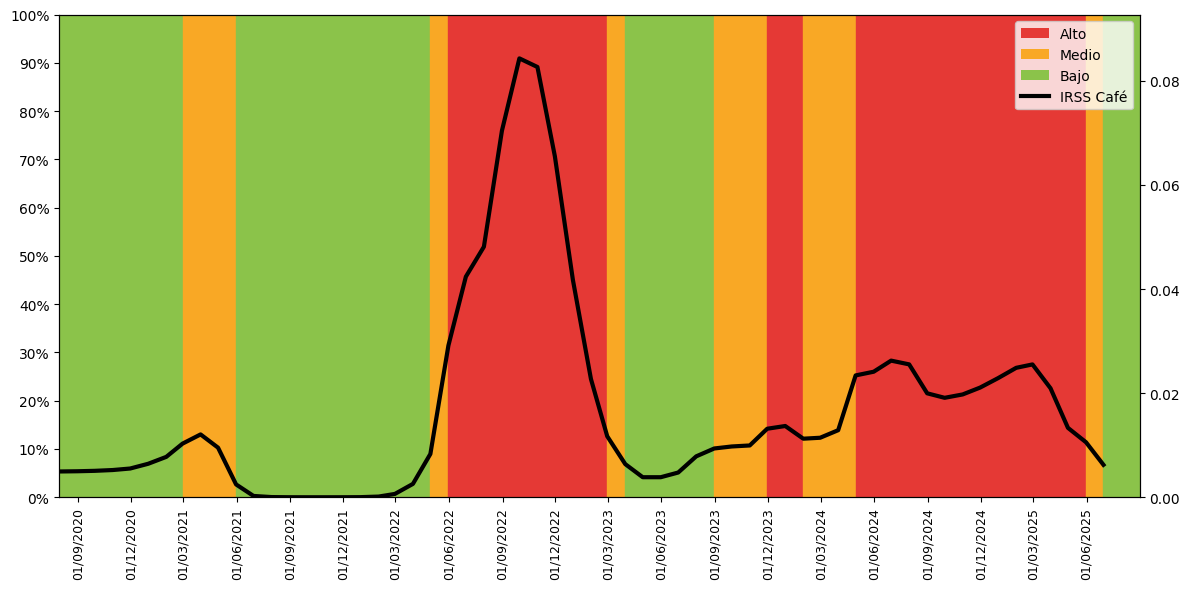

In [13]:
# Gráfico de bandas de riesgo + línea IRSS (corregido para tu archivo data_figirss.xlsx)
# Requiere: pandas, matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# =============== 1) Cargar y preparar ===============
df = pd.read_excel("data_figirss.xlsx", sheet_name="Hoja1")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df = df.sort_values("Fecha").reset_index(drop=True)

# Paleta (igual a tu ejemplo)
COLOR_BAJO  = "#8BC34A"   # verde
COLOR_MEDIO = "#F9A825"   # amarillo
COLOR_ALTO  = "#E53935"   # rojo
COLOR_LINEA = "#000000"   # negro

# Completar NaN en la columna de nivel de riesgo (uso ffill/bfill para evitar FutureWarning)
niveles = (
    df["Riesgo"]
    .ffill()
    .bfill()
    .astype(str)
    .to_numpy()
)
fechas = df["Fecha"].to_numpy()

# Construir tramos consecutivos (runs) de la etiqueta de riesgo
runs = []
start = 0
for i in range(1, len(niveles)):
    if niveles[i] != niveles[i-1]:
        runs.append((start, i-1, niveles[i-1]))
        start = i
runs.append((start, len(niveles)-1, niveles[-1]))

# =============== 2) Figura y ejes ===============
fig, ax = plt.subplots(figsize=(12, 6))

# Eje Y izquierdo como porcentaje 0–100 %
ax.set_ylim(0, 1.0)
ax.set_yticks(np.linspace(0, 1.0, 11))
ax.set_yticklabels([f"{int(t*100)}%" for t in np.linspace(0, 1.0, 11)])

# Pintar bandas por tramo
for i0, i1, nivel in runs:
    x0 = fechas[i0]
    # el final del tramo: usar la fecha siguiente para cubrir el ancho;
    # si es el último punto, extender ~30 días
    if i1 < len(fechas) - 1:
        x1 = fechas[i1+1]
    else:
        x1 = fechas[i1] + pd.Timedelta(days=30)
    color = COLOR_BAJO if nivel == "Bajo" else (COLOR_MEDIO if nivel == "Medio" else COLOR_ALTO)
    ax.axvspan(x0, x1, color=color, alpha=1.0, zorder=0)

# Línea IRSS en eje derecho
ax2 = ax.twinx()
ax2.plot(df["Fecha"], df["IRSS Café"], color=COLOR_LINEA, linewidth=3, zorder=3)

# Escala eje derecho (automática con margen)
ymax = np.nanmax(df["IRSS Café"].to_numpy()) * 1.1
ax2.set_ylim(0, (ymax if np.isfinite(ymax) and ymax > 0 else 0.1))

# =============== 3) Formato eje X ===============
ax.set_xlim(df["Fecha"].min(), df["Fecha"].max())
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))  # portable
for lbl in ax.get_xticklabels():
    lbl.set_rotation(90)
    lbl.set_fontsize(9)

# =============== 4) Leyenda (sin usar legendHandles) ===============
legend_elements = [
    Patch(facecolor=COLOR_ALTO,  edgecolor="none", label="Alto"),
    Patch(facecolor=COLOR_MEDIO, edgecolor="none", label="Medio"),
    Patch(facecolor=COLOR_BAJO,  edgecolor="none", label="Bajo"),
    Line2D([0], [0], color=COLOR_LINEA, lw=3, label="IRSS Café"),
]
ax.legend(handles=legend_elements, loc="upper right", frameon=True)

# Limpieza
ax.grid(False)
ax2.grid(False)
ax.set_ylabel("")
ax2.set_ylabel("")
fig.tight_layout()

# =============== 5) Guardar y mostrar ===============
plt.savefig("fig_irss_bandas.png", dpi=220, bbox_inches="tight")
plt.show()


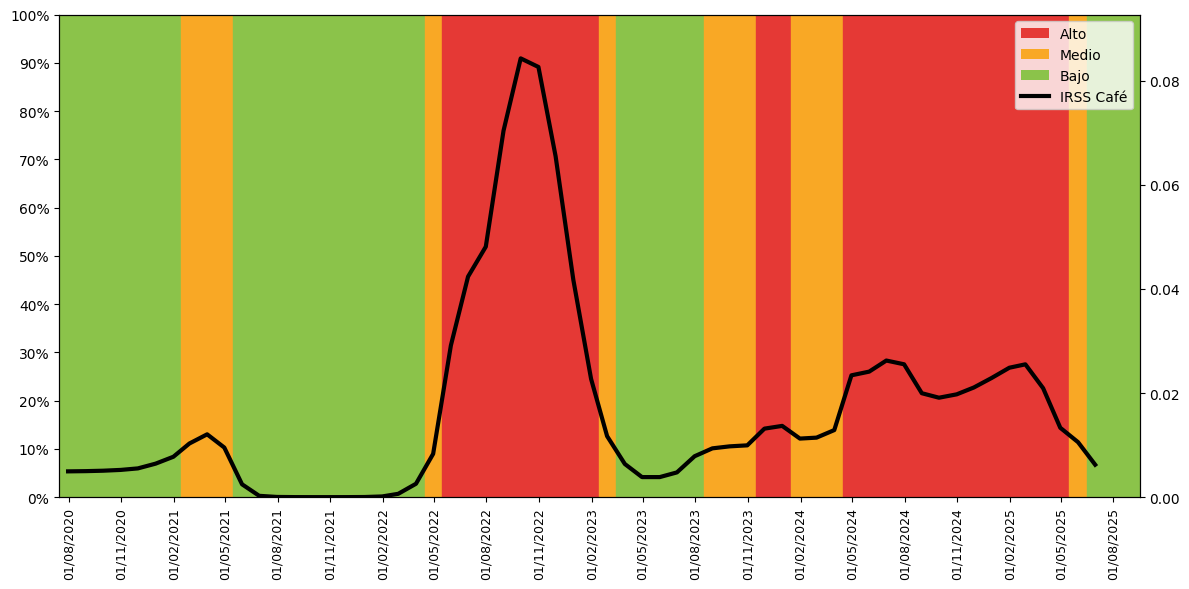

In [14]:
# Gráfico de bandas de riesgo + línea IRSS (bandas centradas por fecha)
# Requiere: pandas, matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# ========= 1) Cargar y preparar =========
df = pd.read_excel("data_figirss.xlsx", sheet_name="Hoja1")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df = df.sort_values("Fecha").reset_index(drop=True)

# Paleta
COLOR_BAJO  = "#8BC34A"   # verde
COLOR_MEDIO = "#F9A825"   # amarillo
COLOR_ALTO  = "#E53935"   # rojo
COLOR_LINEA = "#000000"   # negro

# Series base
fechas  = df["Fecha"].to_numpy()
niveles = df["Riesgo"].ffill().bfill().astype(str).to_numpy()
irss    = df["IRSS Café"].to_numpy()

# ========= 2) Bordes centrados (edges) entre fechas =========
edges = np.empty(len(fechas) + 1, dtype='datetime64[ns]')
edges[1:-1] = (fechas[:-1] + (fechas[1:] - fechas[:-1]) / 2)
edges[0]    = fechas[0]  - (fechas[1]  - fechas[0])  / 2
edges[-1]   = fechas[-1] + (fechas[-1] - fechas[-2]) / 2

# Runs de niveles consecutivos
runs = []
start = 0
for i in range(1, len(niveles)):
    if niveles[i] != niveles[i-1]:
        runs.append((start, i-1, niveles[i-1]))
        start = i
runs.append((start, len(niveles)-1, niveles[-1]))

# ========= 3) Figura y ejes =========
fig, ax = plt.subplots(figsize=(12, 6))

# Y izquierdo como 0–100%
ax.set_ylim(0, 1.0)
yticks = np.linspace(0, 1.0, 11)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{int(t*100)}%" for t in yticks])

# Pintar bandas con edges centrados
for i0, i1, nivel in runs:
    x0 = edges[i0]
    x1 = edges[i1 + 1]
    color = COLOR_BAJO if nivel == "Bajo" else (COLOR_MEDIO if nivel == "Medio" else COLOR_ALTO)
    ax.axvspan(x0, x1, color=color, alpha=1.0, zorder=0)

# Línea IRSS en eje derecho
ax2 = ax.twinx()
ax2.plot(df["Fecha"], irss, color=COLOR_LINEA, linewidth=3, zorder=3)

# Escala eje derecho (con margen)
finite_irss = irss[np.isfinite(irss)]
ymax = (finite_irss.max() * 1.1) if finite_irss.size else 0.1
ax2.set_ylim(0, ymax if ymax > 0 else 0.1)

# ========= 4) Eje X y formato =========
ax.set_xlim(edges[0], edges[-1])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))
for lbl in ax.get_xticklabels():
    lbl.set_rotation(90)
    lbl.set_fontsize(9)

# ========= 5) Leyenda =========
legend_elements = [
    Patch(facecolor=COLOR_ALTO,  edgecolor="none", label="Alto"),
    Patch(facecolor=COLOR_MEDIO, edgecolor="none", label="Medio"),
    Patch(facecolor=COLOR_BAJO,  edgecolor="none", label="Bajo"),
    Line2D([0], [0], color=COLOR_LINEA, lw=3, label="IRSS Café"),
]
ax.legend(handles=legend_elements, loc="upper right", frameon=True)

# Limpieza estética
ax.grid(False); ax2.grid(False)
ax.set_ylabel(""); ax2.set_ylabel("")
fig.tight_layout()

# ========= 6) Guardar/mostrar =========
plt.savefig("fig_irss_bandas_centrada.png", dpi=220, bbox_inches="tight")
plt.show()
